In [19]:
import pickle
import sys
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('/home/dungpa/club_churn_predictionn/')
import configuration.paths as paths
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, precision_score, recall_score, 
    accuracy_score, f1_score, classification_report, roc_auc_score
)
from lime import lime_tabular

# Baseline model

In [20]:
df = pd.read_excel(paths.RAW_DATA + "/club_churn_train.xlsx")

In [21]:
# Handling Missing Values

# For categorical variables
df['MEMBER_MARITAL_STATUS'].fillna('Unknown', inplace=True)
df['MEMBER_GENDER'].fillna('Unknown', inplace=True)

# For numerical variables
df['MEMBER_ANNUAL_INCOME'].fillna(df['MEMBER_ANNUAL_INCOME'].median(), inplace=True)
df['MEMBER_OCCUPATION_CD'].fillna(df['MEMBER_OCCUPATION_CD'].median(), inplace=True)

# Convert START_DATE and END_DATE to datetime format for feature extraction
df['START_DATE'] = pd.to_datetime(df['START_DATE'], format='%Y%m%d', errors='coerce')
df['END_DATE'] = pd.to_datetime(df['END_DATE'], format='%Y%m%d', errors='coerce')

# Encoding the target variable
df['TARGET'] = df['MEMBERSHIP_STATUS'].apply(lambda x: 1 if x == 'CANCELLED' else 0)

# Drop columns that won't be used for model training
df.drop(columns=['ID', 'MEMBERSHIP_NUMBER', 'START_DATE', 'END_DATE', 'MEMBERSHIP_STATUS', 'AGENT_CODE'], inplace=True)

df.head()


MEMBERSHIP_TERM_YEARS  ANNUAL_FEES MEMBER_MARITAL_STATUS MEMBER_GENDER  \
0                   12.0    100000.00               Unknown             M   
1                   17.0    100514.23                     M             F   
2                   12.0    100000.80                     M             M   
3                   12.0    100000.99                     M             M   
4                   12.0    200001.60               Unknown             M   

   MEMBER_ANNUAL_INCOME  MEMBER_OCCUPATION_CD MEMBERSHIP_PACKAGE  \
0              399996.0                   1.0             TYPE-B   
1              549996.0                   1.0             TYPE-A   
2             1299996.0                   1.0             TYPE-B   
3              500004.0                   1.0             TYPE-B   
4              499992.0                   2.0             TYPE-B   

   MEMBER_AGE_AT_ISSUE  ADDITIONAL_MEMBERS PAYMENT_MODE  TARGET  
0                 43.0                 2.0       ANNUAL       1  
1                 40.0                 2.0       ANNUAL       1  
2                 40.0                 2.0      MONTHLY       0  
3                 50.0                 3.0       ANNUAL       1  
4                 45.0                 2.0      MONTHLY       1

In [22]:
# Encoding Categorical Features using One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['MEMBER_MARITAL_STATUS', 'MEMBER_GENDER', 'MEMBERSHIP_PACKAGE', 'PAYMENT_MODE'])
df_encoded.head()

MEMBERSHIP_TERM_YEARS  ANNUAL_FEES  MEMBER_ANNUAL_INCOME  \
0                   12.0    100000.00              399996.0   
1                   17.0    100514.23              549996.0   
2                   12.0    100000.80             1299996.0   
3                   12.0    100000.99              500004.0   
4                   12.0    200001.60              499992.0   

   MEMBER_OCCUPATION_CD  MEMBER_AGE_AT_ISSUE  ADDITIONAL_MEMBERS  TARGET  \
0                   1.0                 43.0                 2.0       1   
1                   1.0                 40.0                 2.0       1   
2                   1.0                 40.0                 2.0       0   
3                   1.0                 50.0                 3.0       1   
4                   2.0                 45.0                 2.0       1   

   MEMBER_MARITAL_STATUS_D  MEMBER_MARITAL_STATUS_M  MEMBER_MARITAL_STATUS_S  \
0                        0                        0                        0   
1                        0                        1                        0   
2                        0                        1                        0   
3                        0                        1                        0   
4                        0                        0                        0   

   ...  MEMBER_GENDER_F  MEMBER_GENDER_M  MEMBER_GENDER_Unknown  \
0  ...                0                1                      0   
1  ...                1                0                      0   
2  ...                0                1                      0   
3  ...                0                1                      0   
4  ...                0                1                      0   

   MEMBERSHIP_PACKAGE_TYPE-A  MEMBERSHIP_PACKAGE_TYPE-B  PAYMENT_MODE_ANNUAL  \
0                          0                          1                    1   
1                          1                          0                    1   
2                          0                          1                    0   
3                          0                          1                    1   
4                          0                          1                    0   

   PAYMENT_MODE_MONTHLY  PAYMENT_MODE_QUARTERLY  PAYMENT_MODE_SEMI-ANNUAL  \
0                     0                       0                         0   
1                     0                       0                         0   
2                     1                       0                         0   
3                     0                       0                         0   
4                     1                       0                         0   

   PAYMENT_MODE_SINGLE-PREMIUM  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0  

[5 rows x 22 columns]

In [23]:
# Features and Target variable
X = df_encoded.drop('TARGET', axis=1)
y = df_encoded['TARGET']

# Splitting the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((7460, 21), (1865, 21))

In [24]:
# Initialize and train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions on the test set
rf_predictions = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluating the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_auc = roc_auc_score(y_test, rf_proba)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)

rf_accuracy, rf_auc, rf_precision, rf_recall

(0.7024128686327078, 0.706829241303368, 0.5276967930029155, 0.3153310104529617)

0    1291
1     574
Name: TARGET, dtype: int64
event rate: 30.78 %
Best Threshold=0.31, G-Mean=0.65


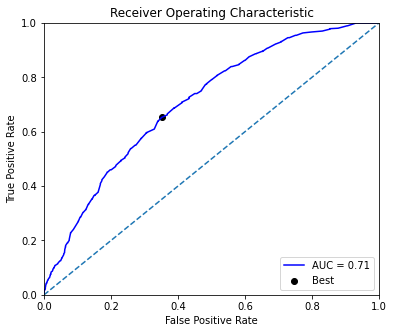

[[837 454]
 [199 375]]


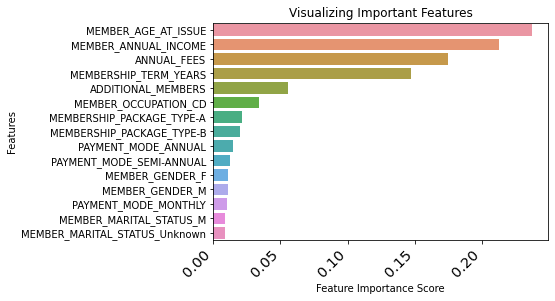

AUC: 0.706829241303368
Index(['proba', 'TARGET', 'sample'], dtype='object')
event rate: 30.78 %
  sample  predict_value_min  predict_value_max  actual_event  actual_nonevent  \
0      1               0.60               0.97           104               83   
1      2               0.49               0.60            92               94   
2      3               0.40               0.49            81              106   
3      4               0.33               0.40            68              118   
4      5               0.28               0.33            60              127   
5      6               0.22               0.28            55              131   
6      7               0.16               0.22            46              140   
7      8               0.10               0.16            38              149   
8      9               0.05               0.10            19              167   
9     10               0.00               0.05            11              176   

   event_rat

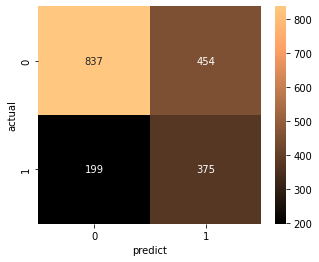

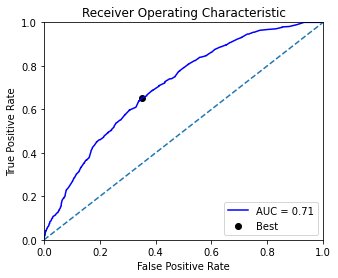

In [26]:
evaluate_model(rf_model, X_test, y_test)

In [11]:
X_train = pd.read_csv(paths.PROCESSED_DATA + "/X_train.csv")
X_test = pd.read_csv(paths.PROCESSED_DATA + "/X_test.csv")
y_train = pd.read_csv(paths.PROCESSED_DATA + "/y_train.csv")
y_test = pd.read_csv(paths.PROCESSED_DATA + "/y_test.csv")

# Compare multiple models

In [12]:
# Initialize and train Random Forest with embedding features
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions on the test set
rf_predictions = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluating the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_auc = roc_auc_score(y_test, rf_proba)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)

rf_accuracy, rf_auc, rf_precision, rf_recall

/tmp/ipykernel_50122/2822612346.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


(0.7442359249329759,
 0.8084203963650791,
 0.6405797101449275,
 0.38501742160278746)

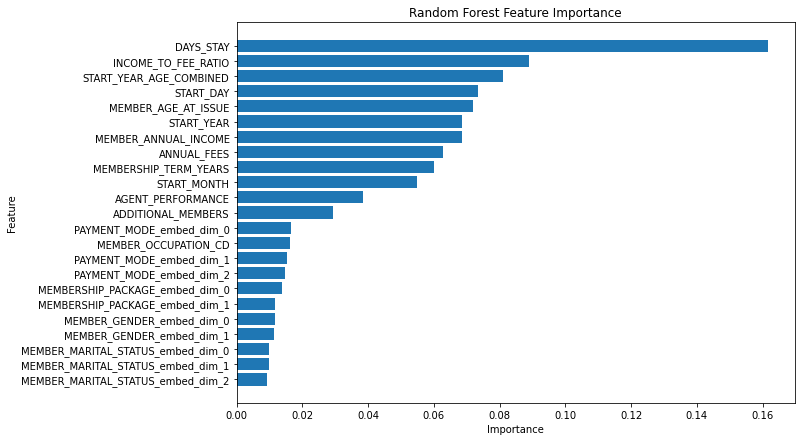

In [13]:
# Get feature importances
importances = rf_model.feature_importances_

# Sort the features by importance
sorted_idx = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 7))
plt.barh(X_train.columns[sorted_idx], importances[sorted_idx])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [14]:
model_path = paths.MODEL_RF + '/rf_model'
with open(model_path, 'wb') as model_file:
    pickle.dump(rf_model, model_file)

In [5]:
# Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

# Predictions on the test set
xgb_predictions = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluating the XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_auc = roc_auc_score(y_test, xgb_proba)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)

xgb_accuracy, xgb_auc, xgb_precision, xgb_recall

(0.7249329758713137, 0.7777510883441247, 0.5676274944567627, 0.445993031358885)

In [6]:
# Initialize and train LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Predictions on the test set
lgb_predictions = lgb_model.predict(X_test)
lgb_proba = lgb_model.predict_proba(X_test)[:, 1]

# Evaluating the LightGBM model
lgb_accuracy = accuracy_score(y_test, lgb_predictions)
lgb_auc = roc_auc_score(y_test, lgb_proba)
lgb_precision = precision_score(y_test, lgb_predictions)
lgb_recall = recall_score(y_test, lgb_predictions)

lgb_accuracy, lgb_auc, lgb_precision, lgb_recall

/data/data_science/envs_python/dungpa/py39/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/data/data_science/envs_python/dungpa/py39/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Number of positive: 2256, number of negative: 5204
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 7460, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.302413 -> initscore=-0.835834
[LightGBM] [Info] Start training from score -0.835834


(0.7378016085790885,
 0.7929568683758099,
 0.6164383561643836,
 0.39198606271777003)

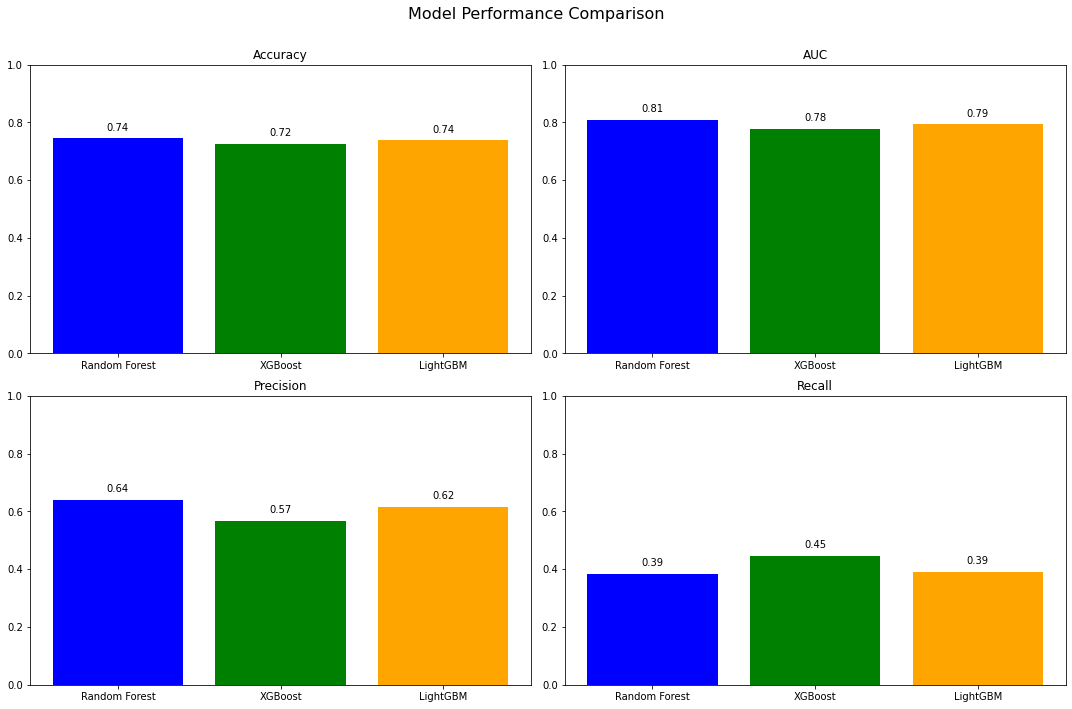

In [7]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['Random Forest', 'XGBoost', 'LightGBM']
accuracy_scores = [rf_accuracy, xgb_accuracy, lgb_accuracy]
auc_scores = [rf_auc, xgb_auc, lgb_auc]
precision_scores = [rf_precision, xgb_precision, lgb_precision]
recall_scores = [rf_recall, xgb_recall, lgb_recall]

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Accuracy
axes[0, 0].bar(models, accuracy_scores, color=['blue', 'green', 'orange'])
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_ylim(0, 1)
for i, v in enumerate(accuracy_scores):
    axes[0, 0].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# AUC
axes[0, 1].bar(models, auc_scores, color=['blue', 'green', 'orange'])
axes[0, 1].set_title('AUC')
axes[0, 1].set_ylim(0, 1)
for i, v in enumerate(auc_scores):
    axes[0, 1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# Precision
axes[1, 0].bar(models, precision_scores, color=['blue', 'green', 'orange'])
axes[1, 0].set_title('Precision')
axes[1, 0].set_ylim(0, 1)
for i, v in enumerate(precision_scores):
    axes[1, 0].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# Recall
axes[1, 1].bar(models, recall_scores, color=['blue', 'green', 'orange'])
axes[1, 1].set_title('Recall')
axes[1, 1].set_ylim(0, 1)
for i, v in enumerate(recall_scores):
    axes[1, 1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# RF evaluation

In [25]:
def evaluate_model(classifier, X_test, y_test, sort_order=False):
    print(y_test.value_counts())
    y_pred_proba = classifier.predict_proba(X_test)
    y_predict_proba_df = pd.DataFrame(y_pred_proba[:,1], columns=["proba"])
    y_test = y_test.reset_index(drop=True)
    y_predict_proba_df = pd.concat([y_predict_proba_df, y_test], axis=1)
    y_predict_proba_df = y_predict_proba_df.sort_values(by="proba",
                                                          ascending=False,
                                                          ignore_index=True)
    _bins = list(np.linspace(0, len(y_predict_proba_df) -1, 11).astype(int))
    _groups = np.arange(1, 11, 1)
    y_predict_proba_df["sample"] = pd.cut(y_predict_proba_df.index, bins=_bins,
                                            labels=_groups, include_lowest=True)

    df = y_predict_proba_df.copy()
    df = df[["proba","TARGET", "sample"]].rename(columns={"proba": "predict_value", 
                                            "TARGET": "actual_event",
                                            "sample": "decile"})
    pd.options.display.float_format = "{:,.2f}".format
    event_rate = 100 * sum(df["actual_event"])/ df.shape[0]
    print("event rate: %0.2f" %event_rate, '%')

    df = df.sort_values("predict_value", ascending = sort_order)
    #roc score
    fpr1, tpr1, threshold1 = roc_curve(df["actual_event"], df["predict_value"])
    roc_auc1 = auc(fpr1, tpr1)
    gmeans = np.sqrt(tpr1 * (1-fpr1))
    ix = np.argmax(gmeans)
    print('Best Threshold=%0.2f, G-Mean=%.2f' % (threshold1[ix], gmeans[ix]))

    df["predict_event"] =  np.where(df['predict_value'] >=threshold1[ix], 1 , 0) 
    cof_matrix = confusion_matrix(df["actual_event"], df["predict_event"]) 
    # roc
    plt.figure(figsize = (6,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % (roc_auc1))
    plt.scatter(fpr1[ix], tpr1[ix], marker='o', color='black', label='Best')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    # Plot confusion matrix
    print(cof_matrix)
    # df_cm = pd.DataFrame(cof_matrix, index=range(0, 2), columns=range(0, 2))
    # confplot.plot_confusion_matrix_from_matrix(df_cm)
    check_feature_importance(classifier, X_test)
    re, proba_df = check_top_40_70(classifier, X_test, y_test)
    print(proba_df.columns)
    score_card(proba_df[["proba","TARGET", "sample"]].rename(columns={"proba": "predict_value", 
                                                                "TARGET": "actual_event"}))

    

def check_feature_importance(classifier, X):
    feature_importances_df = pd.DataFrame(
        {"feature": list(X.columns), "importance": classifier.feature_importances_}
    ).sort_values("importance", ascending=False).iloc[:15,:]
    # visualize important featuers
    # Creating a bar plot
    sns.barplot(x=feature_importances_df.importance,
                y=feature_importances_df.feature)
    # Add labels to your

    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Visualizing Important Features")
    plt.xticks(
        rotation=45, horizontalalignment="right", fontweight="light",
        fontsize="x-large"
    )
    plt.show()
    
    
def check_top_40_70(classifier, X_test, y_test):
    #%% evaluate top customers
    y_pred_proba = classifier.predict_proba(X_test)
    auc = roc_auc_score(y_test.values, y_pred_proba[:,1])
    print("AUC: {}".format(auc))
    y_predict_proba_df = pd.DataFrame(y_pred_proba[:,1], columns=["proba"])
    y_test = y_test.reset_index(drop=True)
    y_predict_proba_df = pd.concat([y_predict_proba_df, y_test], axis=1)
    y_predict_proba_df = y_predict_proba_df.sort_values(by="proba",
                                                        ascending=False,
                                                        ignore_index=True)
    _bins = list(np.linspace(0, len(y_predict_proba_df) -1, 11).astype(int))
    _groups = np.arange(1, 11, 1)
    y_predict_proba_df["sample"] = pd.cut(y_predict_proba_df.index, bins=_bins,
                                          labels=_groups, include_lowest=True)

    result = y_predict_proba_df.groupby("sample")["TARGET"].value_counts().\
        unstack().reset_index()
    result["total"] = result[0] + result[1]
    result["xsell_rate"] = round(result[1]/result["total"],2)*100
    result["xsell_cover_pct"] = round(result[1]/result[1].sum(axis=0),2)*100
    result["xsell_cover_cumsum"] = result["xsell_cover_pct"].cumsum()
    return result, y_predict_proba_df

def score_card(df,sort_direct=False):
    pd.options.display.float_format = "{:,.2f}".format
    event_rate = 100 * sum(df["actual_event"])/ df.shape[0]
    print("event rate: %0.2f" %event_rate, '%')
    
    df = df.sort_values("predict_value", ascending = sort_direct)
    # df['decile'] = 10 -  pd.qcut(df['predict_value'], 10, labels=False)
    df["actual_nonevent"] =  np.where(df["actual_event"] == 0 ,1 ,0)
    df["predict_value_min"] =  df["predict_value"]
    df["predict_value_max"] =  df["predict_value"]
    score_table = df.groupby("sample").agg({
        "predict_value_min":"min",
        "predict_value_max": "max",
        "actual_event": "sum",
        "actual_nonevent" : "sum"
    }).reset_index()
    #ks table
    score_table["event_rate"] = 100 * score_table["actual_event"]/ score_table["actual_event"].sum()
    score_table["non_event_rate"] = 100 * score_table["actual_nonevent"]/ score_table["actual_nonevent"].sum()
    score_table["cum_event_rate"] = 100 * score_table["actual_event"].cumsum()/ score_table["actual_event"].sum()
    score_table["cum_non_event_rate"] = 100 * score_table["non_event_rate"].cumsum()/ score_table["non_event_rate"].sum()
    score_table["ks_score"] = score_table["cum_event_rate"] -  score_table["cum_non_event_rate"]
    print(score_table)
    #roc score
    fpr1, tpr1, threshold1 = roc_curve(df["actual_event"], df["predict_value"])
    roc_auc1 = auc(fpr1, tpr1)
    gmeans = np.sqrt(tpr1 * (1-fpr1))
    ix = np.argmax(gmeans)
    print('Best Threshold=%0.2f, G-Mean=%.2f' % (threshold1[ix], gmeans[ix]))
    
    df["predict_event"] =  np.where(df['predict_value'] >=threshold1[ix], 1 , 0)

    print("Accuracy =%0.2f " % (100 * accuracy_score(df["actual_event"], df["predict_event"])), '%' )
    print("F1 =%0.2f " % f1_score(df["actual_event"], df["predict_event"]))
    print(classification_report(df["actual_event"], df["predict_event"]))
    
    plt.figure(figsize = (5,4))
    cof_matrix = confusion_matrix(df["actual_event"], df["predict_event"])
    sns.heatmap(cof_matrix, annot = True, fmt = 'd', cmap = plt.cm.copper)
    plt.ylabel('actual')
    plt.xlabel('predict')
    plt.show()


    # roc
    plt.figure(figsize = (5,4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % (roc_auc1))
    plt.scatter(fpr1[ix], tpr1[ix], marker='o', color='black', label='Best')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return score_table

TARGET
0         1291
1          574
dtype: int64
event rate: 30.78 %
Best Threshold=0.34, G-Mean=0.73


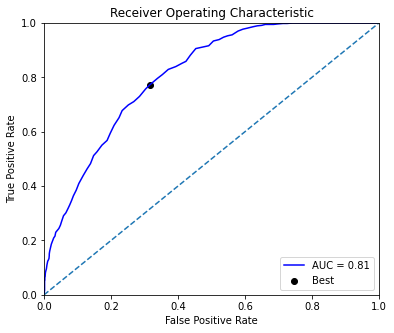

[[882 409]
 [130 444]]


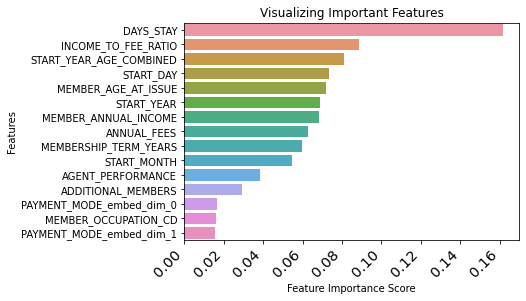

AUC: 0.8084203963650791
Index(['proba', 'TARGET', 'sample'], dtype='object')
event rate: 30.78 %
  sample  predict_value_min  predict_value_max  actual_event  actual_nonevent  \
0      1               0.61               0.97           136               51   
1      2               0.49               0.60           101               85   
2      3               0.43               0.49            86              101   
3      4               0.37               0.43            84              102   
4      5               0.31               0.37            63              124   
5      6               0.25               0.31            51              135   
6      7               0.18               0.25            36              150   
7      8               0.07               0.17            16              171   
8      9               0.01               0.07             1              185   
9     10               0.00               0.01             0              187   

   event_ra

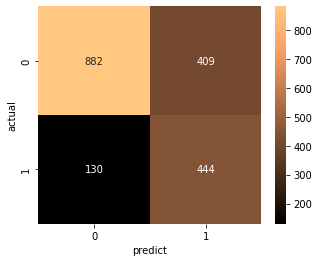

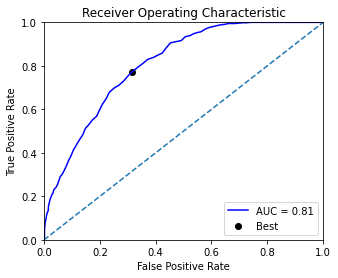

In [9]:
evaluate_model(rf_model, X_test, y_test)

# Hyperprameter tuning

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200, 30],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize a random forest classifier
rf = RandomForestClassifier()

# Initialize grid search with 5-fold cross-validation, optimizing for AUC
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=8, verbose=2)

# Assuming X_train and y_train are your training data and labels
grid_search.fit(X_train, y_train.values.ravel())

# The best parameters can be obtained using:
best_params = grid_search.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total tim

# Re-evaluate

In [16]:
best_params

{'bootstrap': False,
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [17]:
# Initialize and train Random Forest
rf_model = RandomForestClassifier(**best_params,random_state=42)
rf_model.fit(X_train, y_train)

# Predictions on the test set
rf_predictions = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluating the Random Forest model
best_rf_accuracy = accuracy_score(y_test, rf_predictions)
best_rf_auc = roc_auc_score(y_test, rf_proba)
best_rf_precision = precision_score(y_test, rf_predictions)
best_rf_recall = recall_score(y_test, rf_predictions)

best_rf_accuracy, best_rf_auc, best_rf_precision, best_rf_recall

/tmp/ipykernel_50122/1843771477.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


(0.7404825737265416, 0.8052464529292853, 0.652027027027027, 0.3362369337979094)

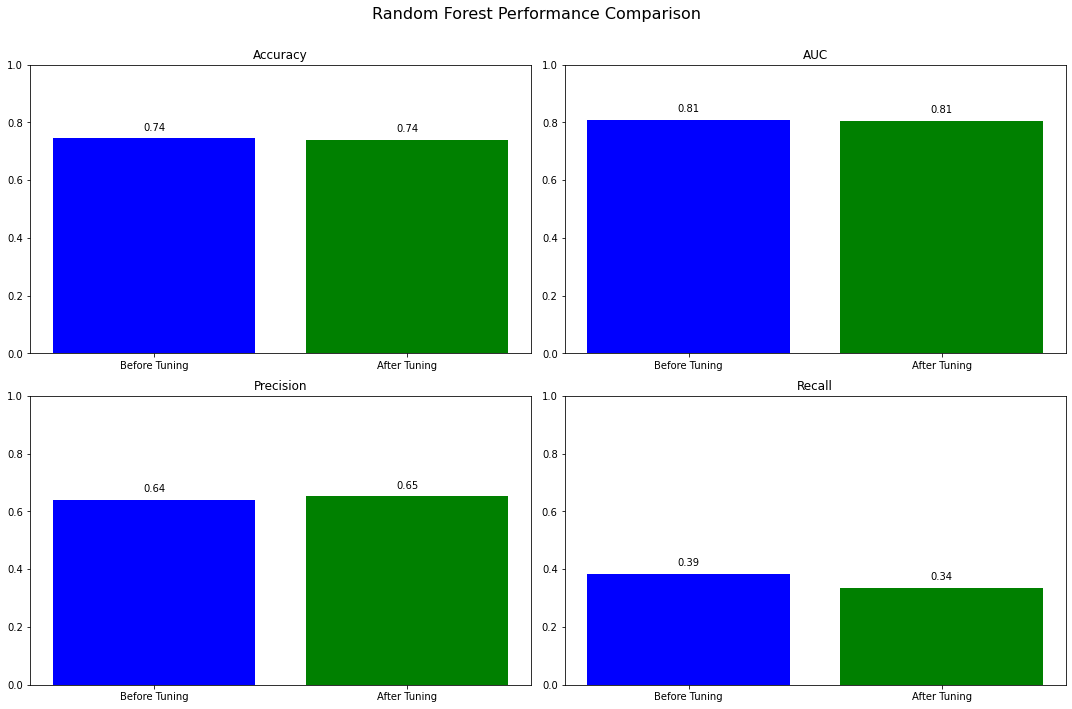

[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=30; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=30; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=30; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, mi

In [18]:
# Data for plotting
models_comparison = ['Before Tuning', 'After Tuning']
accuracy_comparison = [rf_accuracy, best_rf_accuracy]
auc_comparison = [rf_auc, best_rf_auc]
precision_comparison = [rf_precision, best_rf_precision]
recall_comparison = [rf_recall, best_rf_recall]

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Random Forest Performance Comparison', fontsize=16)

# Accuracy
axes[0, 0].bar(models_comparison, accuracy_comparison, color=['blue', 'green'])
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_ylim(0, 1)
for i, v in enumerate(accuracy_comparison):
    axes[0, 0].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# AUC
axes[0, 1].bar(models_comparison, auc_comparison, color=['blue', 'green'])
axes[0, 1].set_title('AUC')
axes[0, 1].set_ylim(0, 1)
for i, v in enumerate(auc_comparison):
    axes[0, 1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# Precision
axes[1, 0].bar(models_comparison, precision_comparison, color=['blue', 'green'])
axes[1, 0].set_title('Precision')
axes[1, 0].set_ylim(0, 1)
for i, v in enumerate(precision_comparison):
    axes[1, 0].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# Recall
axes[1, 1].bar(models_comparison, recall_comparison, color=['blue', 'green'])
axes[1, 1].set_title('Recall')
axes[1, 1].set_ylim(0, 1)
for i, v in enumerate(recall_comparison):
    axes[1, 1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Explainer with LIME 

In [20]:
explainer = lime_tabular.LimeTabularExplainer(X_train.values, 
                                              feature_names=X_train.columns, 
                                              class_names=['INFORCE', 'CANCELLED'], 
                                              mode='classification')


In [21]:
input_data = X_test.iloc[-2].values
exp = explainer.explain_instance(input_data, rf_model.predict_proba)
exp.show_in_notebook()

/data/data_science/envs_python/dungpa/py39/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [22]:
input_data = X_test.iloc[1].values
exp = explainer.explain_instance(input_data, rf_model.predict_proba)
exp.show_in_notebook()

/data/data_science/envs_python/dungpa/py39/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [23]:
exp.as_list()

[('399996.00 < MEMBER_ANNUAL_INCOME <= 549996.00', 0.02315082423154089),
 ('DAYS_STAY > 1462.00', 0.01875466115699308),
 ('MEMBER_AGE_AT_ISSUE <= 37.00', 0.015602244957768211),
 ('START_MONTH <= 3.00', 0.014654353109030792),
 ('0.23 < INCOME_TO_FEE_RATIO <= 0.34', 0.01261255703938762),
 ('MEMBERSHIP_TERM_YEARS > 37.00', -0.012383783309525742),
 ('118218.78 < ANNUAL_FEES <= 194622.18', 0.01189929556877302),
 ('START_YEAR_AGE_COMBINED <= 74370.00', 0.01059704611747733),
 ('PAYMENT_MODE_embed_dim_0 > -1.08', 0.010518850677827117),
 ('START_YEAR <= 2009.00', 0.010430337743079453)]

# Error analysis

In [24]:
cohort_analysis = X_test.copy()
cohort_analysis['y_pred'] = rf_model.predict(X_test)
cohort_analysis['y_proba'] = rf_model.predict_proba(X_test)[:, 1]
cohort_analysis['TARGET'] = y_test

In [25]:
cohort_analysis.to_csv(paths.PROCESSED_DATA + '/cohort_analysis.csv', index=False)

## By age group

In [26]:
df = pd.read_csv(paths.PROCESSED_DATA + '/cohort_analysis.csv')
bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
df['AGE_GROUP'] = pd.cut(df['MEMBER_AGE_AT_ISSUE'], bins=bins, labels=labels, right=False)

In [27]:
# Calculating the distribution of each age group
age_group_counts = df['AGE_GROUP'].value_counts(normalize=True).reindex(labels) * 100

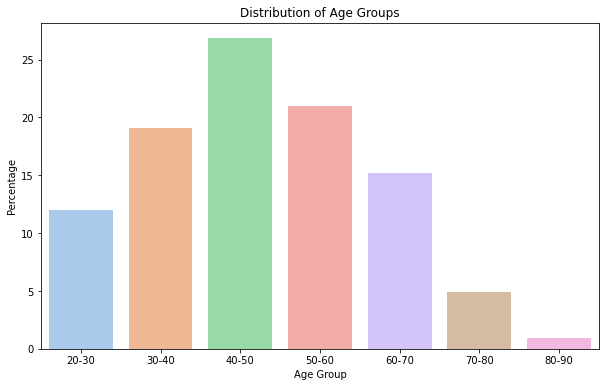

In [28]:
# Plotting the distribution of each age group
plt.figure(figsize=(10, 6))
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette='pastel')
plt.title('Distribution of Age Groups')
plt.ylabel('Percentage')
plt.xlabel('Age Group')
plt.show()

In [29]:
# Placeholder lists for metrics
accuracies = []
auc_scores = []
precisions = []
recalls = []

# Iterate over each age group and calculate metrics
for label in labels:
    subset = df[df['AGE_GROUP'] == label]
    y_true = subset['TARGET']
    y_pred = subset['y_pred']
    y_prob = subset['y_proba']

    # Calculate metrics
    accuracies.append(accuracy_score(y_true, y_pred))
    auc_scores.append(roc_auc_score(y_true, y_prob))
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))

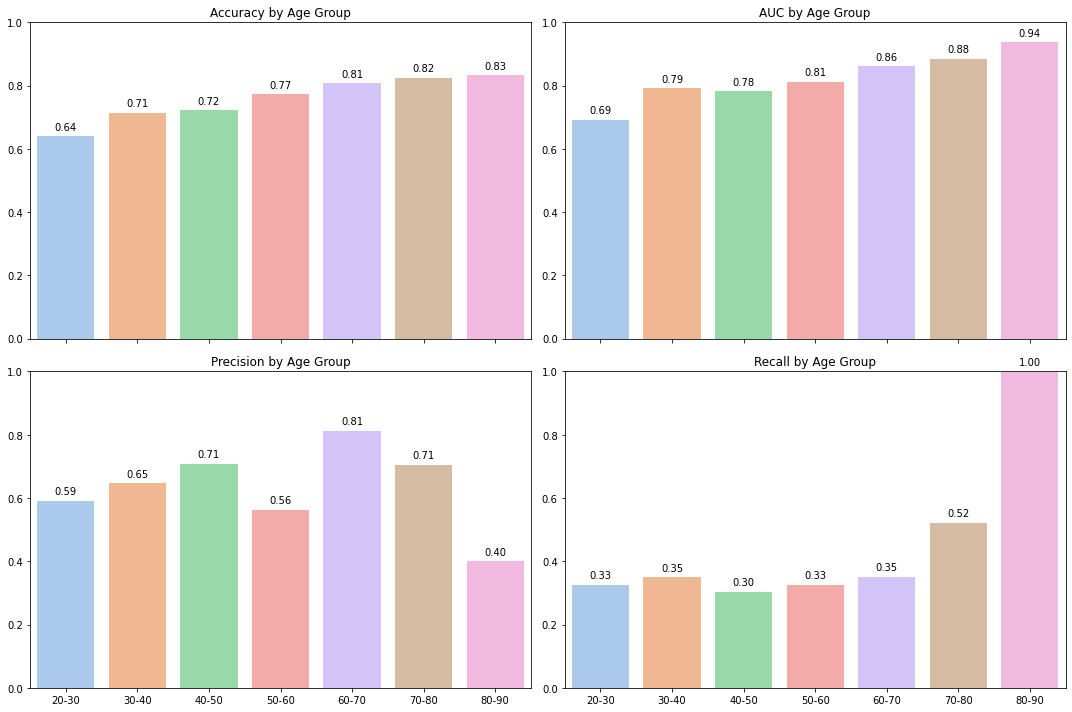

In [30]:
# Plotting the performance metrics for each age group in 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

# Accuracy by Age Group
sns.barplot(x=labels, y=accuracies, ax=axes[0, 0], palette='pastel')
axes[0, 0].set_title('Accuracy by Age Group')
axes[0, 0].set_ylim(0, 1)
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.02, f'{v:.2f}', ha='center')

# AUC by Age Group
sns.barplot(x=labels, y=auc_scores, ax=axes[0, 1], palette='pastel')
axes[0, 1].set_title('AUC by Age Group')
axes[0, 1].set_ylim(0, 1)
for i, v in enumerate(auc_scores):
    axes[0, 1].text(i, v + 0.02, f'{v:.2f}', ha='center')

# Precision by Age Group
sns.barplot(x=labels, y=precisions, ax=axes[1, 0], palette='pastel')
axes[1, 0].set_title('Precision by Age Group')
axes[1, 0].set_ylim(0, 1)
for i, v in enumerate(precisions):
    axes[1, 0].text(i, v + 0.02, f'{v:.2f}', ha='center')

# Recall by Age Group
sns.barplot(x=labels, y=recalls, ax=axes[1, 1], palette='pastel')
axes[1, 1].set_title('Recall by Age Group')
axes[1, 1].set_ylim(0, 1)
for i, v in enumerate(recalls):
    axes[1, 1].text(i, v + 0.02, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

## By START_YEAR

In [31]:
# Calculating performance metrics for each year group
labels = df['START_YEAR'].unique()
years = df['START_YEAR'].unique()
accuracies_year = []
auc_scores_year = []
precisions_year = []
recalls_year = []

for year in years:
    subset = df[df['START_YEAR'] == year]
    accuracies_year.append(accuracy_score(subset['TARGET'], subset['y_pred']))
    auc_scores_year.append(roc_auc_score(subset['TARGET'], subset['y_proba']))
    precisions_year.append(precision_score(subset['TARGET'], subset['y_pred']))
    recalls_year.append(recall_score(subset['TARGET'], subset['y_pred']))

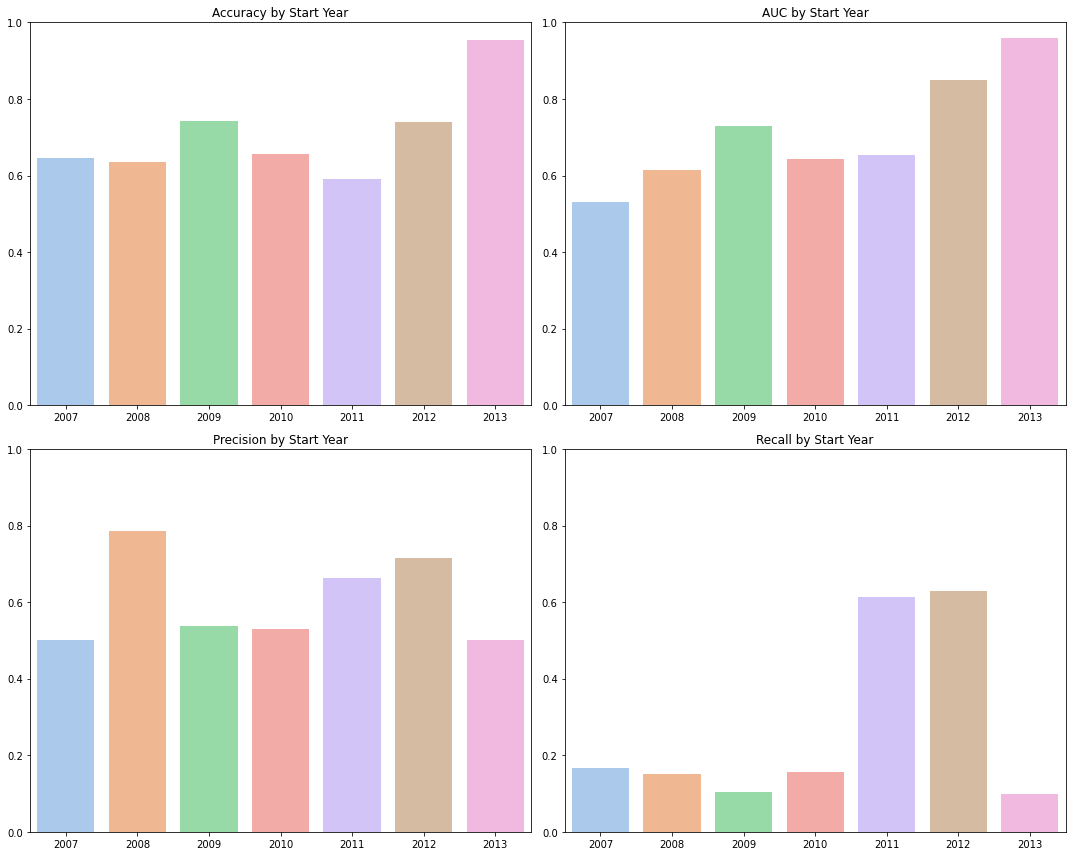

In [32]:
# Plotting the performance metrics for each year group in 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy by Year Group
sns.barplot(x=labels, y=accuracies_year, ax=axes[0, 0], palette='pastel')
axes[0, 0].set_title('Accuracy by Start Year')
axes[0, 0].set_ylim(0, 1)
# for i, v in enumerate(accuracies_year):
#     axes[0, 0].text(i, v + 0.02, f'{v:.2f}', ha='center')

# AUC by Year Group
sns.barplot(x=labels, y=auc_scores_year, ax=axes[0, 1], palette='pastel')
axes[0, 1].set_title('AUC by Start Year')
axes[0, 1].set_ylim(0, 1)
# for i, v in enumerate(auc_scores_year):
#     axes[0, 1].text(i, v + 0.02, f'{v:.2f}', ha='center')

# Precision by Year Group
sns.barplot(x=labels, y=precisions_year, ax=axes[1, 0], palette='pastel')
axes[1, 0].set_title('Precision by Start Year')
axes[1, 0].set_ylim(0, 1)
# for i, v in enumerate(precisions_year):
#     axes[1, 0].text(i, v + 0.02, f'{v:.2f}', ha='center')

# Recall by Year Group
sns.barplot(x=labels, y=recalls_year, ax=axes[1, 1], palette='pastel')
axes[1, 1].set_title('Recall by Start Year')
axes[1, 1].set_ylim(0, 1)
# for i, v in enumerate(recalls_year):
#     axes[1, 1].text(i, v + 0.02, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

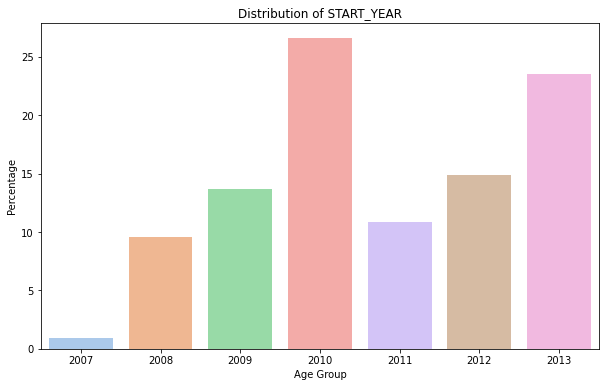

In [33]:
# Calculating the distribution of each age group
age_group_counts = df['START_YEAR'].value_counts(normalize=True).reindex(labels) * 100
# Plotting the distribution of each age group
plt.figure(figsize=(10, 6))
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette='pastel')
plt.title('Distribution of START_YEAR')
plt.ylabel('Percentage')
plt.xlabel('Age Group')
plt.show()

## Member tenure

In [34]:
stay_bins = [0, 200, 400, np.inf]
stay_labels = ['Below 200 days', '200-400 days', 'Above 400 days']
df['Stay_Group'] = pd.cut(df['DAYS_STAY'], bins=stay_bins, labels=stay_labels, right=True)

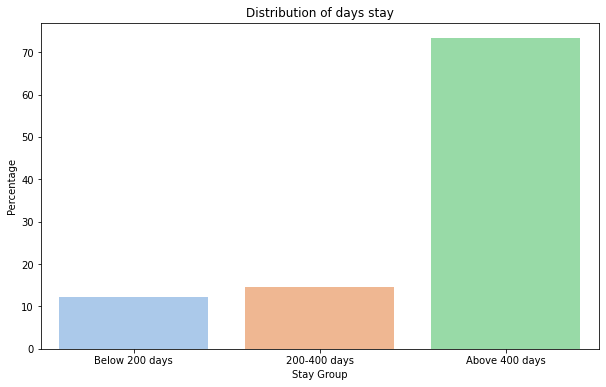

In [35]:
# Calculating the distribution of each age group
stay_group_counts = df['Stay_Group'].value_counts(normalize=True).reindex(stay_labels) * 100
# Plotting the distribution of each age group
plt.figure(figsize=(10, 6))
sns.barplot(x=stay_group_counts.index, y=stay_group_counts.values, palette='pastel')
plt.title('Distribution of days stay')
plt.ylabel('Percentage')
plt.xlabel('Stay Group')
plt.show()

In [36]:
# Calculating performance metrics for each year group
labels = df['Stay_Group'].unique()
stay_groups = df['Stay_Group'].unique()
accuracies_year = []
auc_scores_year = []
precisions_year = []
recalls_year = []

for group in stay_groups:
    subset = df[df['Stay_Group'] == group]
    accuracies_year.append(accuracy_score(subset['TARGET'], subset['y_pred']))
    auc_scores_year.append(roc_auc_score(subset['TARGET'], subset['y_proba']))
    precisions_year.append(precision_score(subset['TARGET'], subset['y_pred']))
    recalls_year.append(recall_score(subset['TARGET'], subset['y_pred']))

/data/data_science/envs_python/dungpa/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


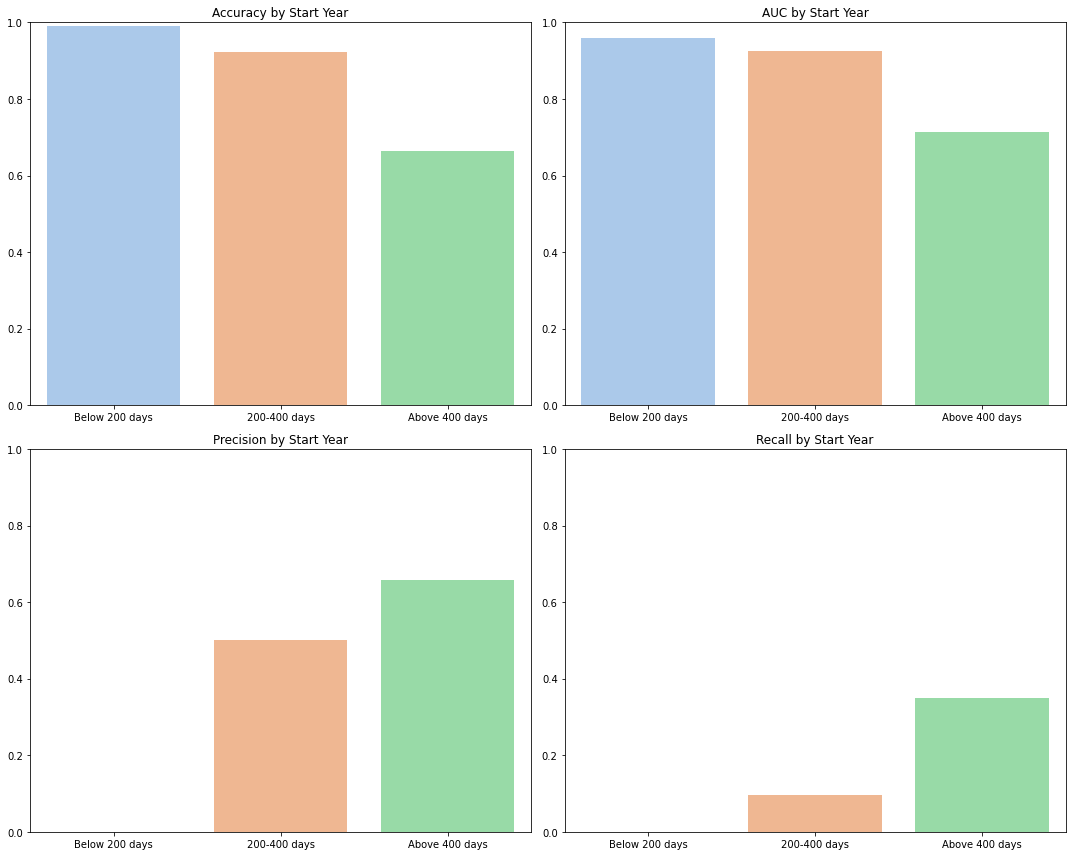

In [37]:
# Plotting the performance metrics for each year group in 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy by Year Group
sns.barplot(x=labels, y=accuracies_year, ax=axes[0, 0], palette='pastel')
axes[0, 0].set_title('Accuracy by Start Year')
axes[0, 0].set_ylim(0, 1)
# for i, v in enumerate(accuracies_year):
#     axes[0, 0].text(i, v + 0.02, f'{v:.2f}', ha='center')

# AUC by Year Group
sns.barplot(x=labels, y=auc_scores_year, ax=axes[0, 1], palette='pastel')
axes[0, 1].set_title('AUC by Start Year')
axes[0, 1].set_ylim(0, 1)
# for i, v in enumerate(auc_scores_year):
#     axes[0, 1].text(i, v + 0.02, f'{v:.2f}', ha='center')

# Precision by Year Group
sns.barplot(x=labels, y=precisions_year, ax=axes[1, 0], palette='pastel')
axes[1, 0].set_title('Precision by Start Year')
axes[1, 0].set_ylim(0, 1)
# for i, v in enumerate(precisions_year):
#     axes[1, 0].text(i, v + 0.02, f'{v:.2f}', ha='center')

# Recall by Year Group
sns.barplot(x=labels, y=recalls_year, ax=axes[1, 1], palette='pastel')
axes[1, 1].set_title('Recall by Start Year')
axes[1, 1].set_ylim(0, 1)
# for i, v in enumerate(recalls_year):
#     axes[1, 1].text(i, v + 0.02, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()